In [2]:
from pyprojroot import here
root = here()
import sys
sys.path.append(str(root))

import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt

In [3]:
food_df = pd.read_feather('../../data/local/molecule/full/food/1_processed.feather')
content_df = pd.read_feather('../../data/local/molecule/full/content/1_processed.feather')
compound_df = pd.read_feather('../../data/local/molecule/full/compound/1_processed.feather')

In [4]:
content_df

food_name                                  source_name  \
food_id source_id                                                               
1       236             angelica                     5-p-Coumaroylquinic acid   
        316             angelica               3,4-Dihydroxyphenylacetic acid   
        432             angelica                                  Moupinamide   
        442             angelica                           2'-Hydroxydaidzein   
        446             angelica                                   L-Tyrosine   
...                          ...                                          ...   
1024    124819     tostada shell                      PG(22:1(13Z)/22:1(13Z))   
        124820     tostada shell  CL(22:1(13Z)/22:1(13Z)/22:1(13Z)/22:1(13Z))   
1025    15423        baking soda                    Sodium hydrogen carbonate   
1026    13358      baking powder                      Calcium phosphate (1:1)   
        15423      baking powder                    Sodium hydrogen carbonate   

                   concentration orig_citation     citation  orig_food_id  \
food_id source_id                                                           
1       236                 <NA>          <NA>       MANUAL          <NA>   
        316                 <NA>          <NA>       MANUAL          <NA>   
        432                 <NA>          <NA>       MANUAL          <NA>   
        442                 <NA>          <NA>       MANUAL          <NA>   
        446                 <NA>          <NA>       MANUAL          <NA>   
...                          ...           ...          ...           ...   
1024    124819              <NA>          <NA>     PATHBANK          <NA>   
        124820              <NA>          <NA>     PATHBANK          <NA>   
1025    15423           100000.0          <NA>  MANUAL_HAND          <NA>   
1026    13358            10000.0          <NA>  MANUAL_HAND          <NA>   
        15423            30000.0          <NA>  MANUAL_HAND          <NA>   

                        orig_food_common_name orig_food_part  
food_id source_id                                             
1       236                                             <NA>  
        316                                             <NA>  
        432                                             <NA>  
        442                                             <NA>  
        446                                             <NA>  
...                                       ...            ...  
1024    124819     lipid arabidopsis pathbank           <NA>  
        124820     lipid arabidopsis pathbank           <NA>  
1025    15423                                           <NA>  
1026    13358                                           <NA>  
        15423                                           <NA>  

[4664511 rows x 8 columns]

# Formatting

Here we have entries of each compound measurement - measured in a standardised concentration of mg/100g. What we want to form is a table of the foods, with features for the concentration of each chemical compound. 


### Handling NA's

#### Content DF

The NA measuremnets coming from this dataset we have already established as seen compounds, but without having thier concentrations measured. How do we deal with this numerically?

Since they are registered as being seen, we should have a (>0) value for them. What makes the most sense is to use the total mean of this value.

#### Expanded DF

Since the data here comes from various sources, there is not a standardised set of measured compounds, so not all foods will have the full featureset. These NA's can be filled as 0, as there was no study which registered them as being present.

In [5]:
content_df['concentration'].notnull().sum() / content_df.index.get_level_values(1).nunique()

9.853602148709754

In [6]:
mean_source_concentrations = content_df.groupby('source_id').apply(lambda item: item['concentration'].mean(skipna=True))
mean_source_concentrations

source_id
4            0.38438
13          1.223154
14        535.347763
24          0.113715
25          0.902589
             ...    
139984          <NA>
139985          <NA>
139986          <NA>
139987          <NA>
139988          <NA>
Length: 58826, dtype: object

Filtering compounds without any measured values.

In [7]:
content_df = content_df.loc[~content_df.index.get_level_values(1).isin(mean_source_concentrations.index[mean_source_concentrations.isna()])]

In [8]:
mean_source_concentrations = content_df.groupby('source_id').apply(lambda item: item['concentration'].mean(skipna=True))
assert mean_source_concentrations.isna().sum() == 0

In [9]:
content_df = content_df.reset_index(0)
content_df['concentration'] = content_df['concentration'].fillna(mean_source_concentrations)
content_df = content_df.reset_index().set_index(['food_id', 'source_id'])

In [10]:
pivoted = pd.pivot_table(content_df, index='food_id', columns='source_id', values='concentration', aggfunc='mean', fill_value=pd.NA)
pivoted

source_id,4,13,14,24,25,27,31,35,40,41,...,125217,125218,125219,125220,125221,125222,125223,125225,125226,125227
food_id,,,,,,,,,,,,,,,,,,,,,
1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1023,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1024,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


# Similarity Measures

Here we are tryign to get a feel for how well these features can be used to distinguish between similar ingredients. If we can find clusters, and similar scores between foods which are indeed similar eg. different fish, we will have a good indicator for the effectiveness of these embeddings.

However this is not an exclusive method for doing so. There are more components as part of the transformer decoder which can help find relationships between each ingredient (I think?). #TODO: validate this - what is the NN component in the decoder used for?

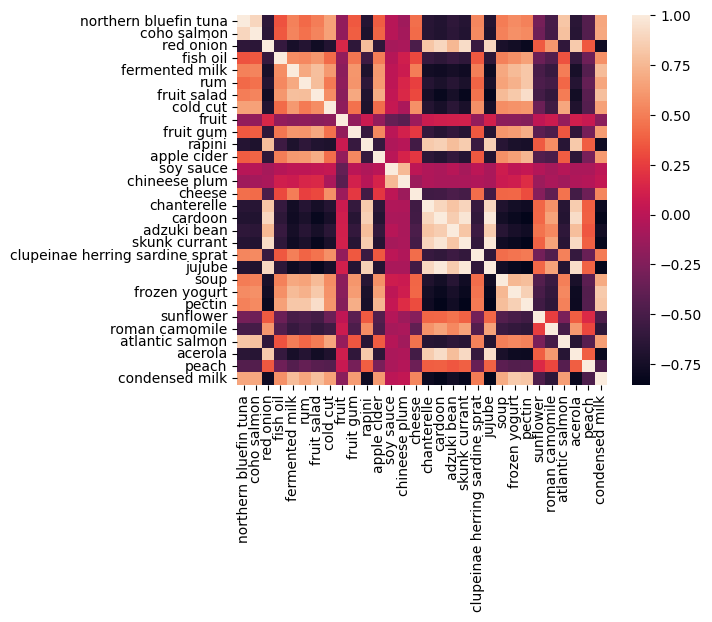

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.preprocessing import StandardScaler

df = pivoted.sample(30, random_state=777)
foods = food_df['name'].loc[df.index]

scaler = StandardScaler()

df_normalized = scaler.fit_transform(df)

cos_sim_df = cosine_similarity(df)
cos_sim_df = cosine_similarity(df_normalized)
sns.heatmap(cos_sim_df, square=True, annot=False, xticklabels=foods, yticklabels=foods);

This shows a bit of promise. Fruits (nectarine, winter squash, kumquat) are giving high similarity scores between eachtoher. Dairy - milk, butter, egg also.

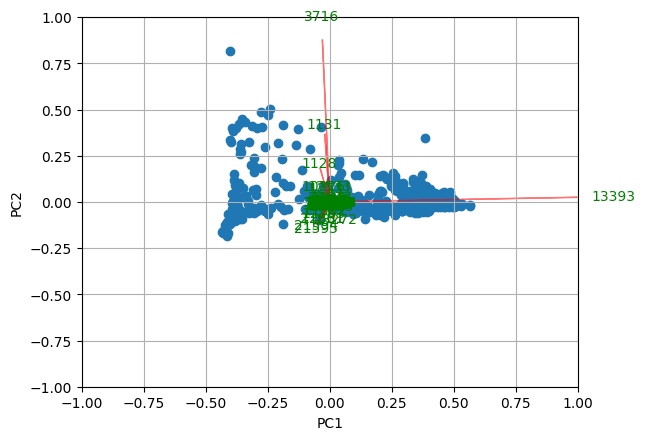

In [23]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

x = pivoted
# y = clusters  

pca = PCA()
x_scaled = StandardScaler().fit_transform(x)
# x_new = pca.fit_transform(x_scaled)
x_pca = pca.fit_transform(x)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    # plt.scatter(xs * scalex,ys * scaley, c = y)
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_pca[:,0:2],np.transpose(pca.components_[0:2, :]), x.columns)
plt.show()

<BarContainer object of 5 artists>

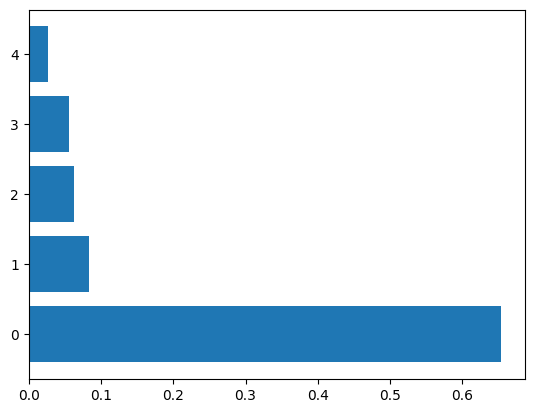

In [24]:
plt.barh(range(0,5), pca.explained_variance_ratio_[:5])

In [25]:
content_df[content_df.index.get_level_values(1).isin((13393,3716,1131,1128))].drop_duplicates(subset='source_name')

food_name source_name  concentration orig_citation citation  \
food_id source_id                                                               
1       1131       angelica     Sucrose    3179.625912          <NA>   MANUAL   
4       1128           kiwi      Starch            0.0          <NA>      DTU   
        3716           kiwi      Sugars         6700.0          <NA>      DTU   
        13393          kiwi    Moisture        84400.0          <NA>      DTU   

                   orig_food_id orig_food_common_name orig_food_part  
food_id source_id                                                     
1       1131               <NA>                                 <NA>  
4       1128                465        kiwi fruit raw           <NA>  
        3716                465        kiwi fruit raw           <NA>  
        13393               465        kiwi fruit raw           <NA>

Yes this does work in some sense, however as can be seen from PCA, the primary component, which accounts for 65% of the variance, is contributed almost entirely by only one feature here and that's water content. You would think that the variance should be more spread out if you want important features. We could possibly remove these features?

# Tokenisation

We can approach this in a number of ways. 

- Tokenize recipes_db ingredients - more refined and varied: requires generalising
- Tokenize molecule_db ingredinets - more generic and less varied: requires refining (eg. dried ingredients)
- Tokenize joined ingredinets - final dataset has the join of ingredients which definitely work together

It actually only makes sense to do it on the molecue_db as there are no duplicates here. 

Also, *duh* more obviously, the tokens will be embedded by their concentrations so it only makes sense to use the ones with entries in the molecule_db.

In [26]:
content_df[~content_df.index.get_level_values(0).duplicated(keep='first')]

,,food_name,source_name,concentration,orig_citation,citation,orig_food_id,orig_food_common_name,orig_food_part
food_id,source_id,,,,,,,,
1,236,angelica,5-p-Coumaroylquinic acid,0.109333,<NA>,MANUAL,<NA>,,<NA>
4,108,kiwi,Procyanidin trimer EEC,0.0,<NA>,PHENOL EXPLORER,156,kiwi,<NA>
5,236,allium,5-p-Coumaroylquinic acid,0.109333,<NA>,MANUAL,<NA>,,<NA>
6,64,garden onion,Cyanidin 3-O-(6''-malonyl-3''-glucosyl-glucoside),1.0,<NA>,PHENOL EXPLORER,256,onion [red] raw,<NA>
7,236,leek,5-p-Coumaroylquinic acid,0.109333,<NA>,MANUAL,<NA>,,<NA>
...,...,...,...,...,...,...,...,...,...
1022,446,fish oil,L-Tyrosine,0.0,<NA>,DTU,884,fish oil hydrogenated,<NA>
1023,446,taco shell,L-Tyrosine,223.0,<NA>,USDA,18360,taco shell baked,<NA>
1024,574,tostada shell,Pyridoxine,0.363,<NA>,USDA,18952,tostada shell corn,<NA>


Do we want to keep all of the ingredients here? Yes, aside from the ones that are deemed problematic - either through lack of data or confusion in names.

One thing here is that we'd want to expand on the ingredients on variations which change them eg. dried, cooked, ground. 

This can be done by searching each food content's for these keywords, and separating these out into their own entries.

In [27]:
food_id = food_df.index[food_df['name'].str.lower().str.contains('apricot')]
food_contents = content_df.loc[food_id]
food_contents[food_contents['orig_food_common_name'].str.lower().str.contains('dried')]

food_name                               source_name  \
food_id source_id                                                       
144     446         apricot                                L-Tyrosine   
        446         apricot                                L-Tyrosine   
        446         apricot                                L-Tyrosine   
        446         apricot                                L-Tyrosine   
        446         apricot                                L-Tyrosine   
...                     ...                                       ...   
        21981       apricot                                     C24:0   
        21981       apricot                                     C24:0   
        21989       apricot  7Z,10Z,13Z,16Z,19Z-Docosapentaenoic acid   
        23049       apricot                                 Cobalamin   
        24096       apricot                           D-Aspartic acid   

                   concentration orig_citation citation  orig_food_id  \
food_id source_id                                                       
144     446                 36.0          <NA>      DTU             1   
        446                 39.0          <NA>     USDA          9032   
        446                 14.0          <NA>     USDA          9033   
        446                 27.0          <NA>     USDA          9034   
        446                 36.0          <NA>      DTU             1   
...                          ...           ...      ...           ...   
        21981                0.0          <NA>      DTU             1   
        21981                0.0          <NA>     USDA          9032   
        21989                0.0          <NA>      DTU             1   
        23049                0.0          <NA>      DTU             1   
        24096              580.0          <NA>      DTU             1   

                                               orig_food_common_name  \
food_id source_id                                                      
144     446                                            apricot dried   
        446                          apricot dried sulfured uncooked   
        446        apricot dried sulfured stewed without added sugar   
        446                apricot dried sulfured stewed added sugar   
        446                                            apricot dried   
...                                                              ...   
        21981                                          apricot dried   
        21981                        apricot dried sulfured uncooked   
        21989                                          apricot dried   
        23049                                          apricot dried   
        24096                                          apricot dried   

                  orig_food_part  
food_id source_id                 
144     446                 <NA>  
        446                 <NA>  
        446                 <NA>  
        446                 <NA>  
        446                 <NA>  
...                          ...  
        21981               <NA>  
        21981               <NA>  
        21989               <NA>  
        23049               <NA>  
        24096               <NA>  

[312 rows x 8 columns]

In [28]:
pd.options.mode.chained_assignment = None  # default='warn'

In [29]:
sampled_df = content_df.sample(10000)

In [33]:
keywords = ['dried', 'cook']
grouped = content_df.copy(deep=True)
grouped['orig_food_common_name'] = grouped['orig_food_common_name'].str.lower()

def split_foods_on_keywords(content_df, keywords):

    grouped = content_df.copy(deep=True)
    grouped['orig_food_common_name'] = grouped['orig_food_common_name'].str.lower()

    for keyword in keywords:
        grouped = grouped.groupby('food_id', as_index=True).apply(
            lambda item: item.groupby(item['orig_food_common_name'].str.contains(keyword), as_index=False).apply(lambda item: item)
        )
        grouped = grouped.droplevel(2)
        grouped.index = grouped.index.rename(['food_id', f'keyword_match_{keyword}', 'source_id'])
        grouped = grouped.reset_index().set_index(['food_id', 'source_id'])

    return grouped

split_foods_df = split_foods_on_keywords(content_df, keywords)
split_foods_df

keyword_match_cook  keyword_match_dried      food_name  \
food_id source_id                                                           
1       236                         0                    0       angelica   
        316                         0                    0       angelica   
        446                         0                    0       angelica   
        474                         0                    0       angelica   
        484                         0                    0       angelica   
...                               ...                  ...            ...   
1024    122510                      0                    0  tostada shell   
        123210                      0                    0  tostada shell   
1025    15423                       0                    0    baking soda   
1026    13358                       0                    0  baking powder   
        15423                       0                    0  baking powder   

                                       source_name  concentration  \
food_id source_id                                                   
1       236               5-p-Coumaroylquinic acid       0.109333   
        316         3,4-Dihydroxyphenylacetic acid       1.386966   
        446                             L-Tyrosine     422.779168   
        474                               L-Lysine     998.946623   
        484                                Glycine     651.838176   
...                                            ...            ...   
1024    122510     TG(20:1(11Z)/18:2(9Z,12Z)/16:0)      24.419212   
        123210          PC(18:2(9Z,12Z)/20:1(13Z))       0.023016   
1025    15423            Sodium hydrogen carbonate       100000.0   
1026    13358              Calcium phosphate (1:1)        10000.0   
        15423            Sodium hydrogen carbonate        30000.0   

                  orig_citation     citation  orig_food_id  \
food_id source_id                                            
1       236                <NA>       MANUAL          <NA>   
        316                <NA>       MANUAL          <NA>   
        446                <NA>       MANUAL          <NA>   
        474                <NA>       MANUAL          <NA>   
        484                <NA>       MANUAL          <NA>   
...                         ...          ...           ...   
1024    122510             <NA>     PATHBANK          <NA>   
        123210             <NA>     PATHBANK          <NA>   
1025    15423              <NA>  MANUAL_HAND          <NA>   
1026    13358              <NA>  MANUAL_HAND          <NA>   
        15423              <NA>  MANUAL_HAND          <NA>   

                        orig_food_common_name orig_food_part  
food_id source_id                                             
1       236                                             <NA>  
        316                                             <NA>  
        446                                             <NA>  
        474                                             <NA>  
        484                                             <NA>  
...                                       ...            ...  
1024    122510     lipid arabidopsis pathbank           <NA>  
        123210     lipid arabidopsis pathbank           <NA>  
1025    15423                                           <NA>  
1026    13358                                           <NA>  
        15423                                           <NA>  

[739552 rows x 10 columns]

In [34]:
assert split_foods_df.shape[0] == content_df.shape[0]
assert not split_foods_df[split_foods_df['keyword_match_dried'] == 1].empty

In [37]:
def reindex_split_foods(split_foods_df, keywords):    

    reindexed = split_foods_df.copy(deep=True)
    reindexed['food_id_new'] = reindexed.index.get_level_values(0)

    for keyword in keywords:

        # reindexing based on unique 'food_id' and 'keyword_match'
        reindexed = reindexed.reset_index().set_index(['food_id_new',f'keyword_match_{keyword}'])
        keyword_names = reindexed[~reindexed.index.duplicated()]
        keyword_names = keyword_names.reset_index()
        keyword_names.index.rename('food_id_new_keyword', inplace=True)
        index_mapping = keyword_names.reset_index().set_index(['food_id_new', f'keyword_match_{keyword}'])['food_id_new_keyword']

        reindexed = reindexed.reset_index().set_index(['food_id_new', f'keyword_match_{keyword}']).join(index_mapping)
        reindexed = reindexed.reset_index().drop('food_id_new', axis=1).rename({'food_id_new_keyword': 'food_id_new'}, axis=1).set_index(['food_id_new', 'source_id'])

    return reindexed

reindexed_split_foods_df = reindex_split_foods(split_foods_df, keywords)
reindexed_split_foods_df

keyword_match_cook  keyword_match_dried  food_id  \
food_id_new source_id                                                     
0           236                         0                    0        1   
            316                         0                    0        1   
            446                         0                    0        1   
            474                         0                    0        1   
            484                         0                    0        1   
...                                   ...                  ...      ...   
1158        122510                      0                    0     1024   
            123210                      0                    0     1024   
1159        15423                       0                    0     1025   
1160        13358                       0                    0     1026   
            15423                       0                    0     1026   

                           food_name                      source_name  \
food_id_new source_id                                                   
0           236             angelica         5-p-Coumaroylquinic acid   
            316             angelica   3,4-Dihydroxyphenylacetic acid   
            446             angelica                       L-Tyrosine   
            474             angelica                         L-Lysine   
            484             angelica                          Glycine   
...                              ...                              ...   
1158        122510     tostada shell  TG(20:1(11Z)/18:2(9Z,12Z)/16:0)   
            123210     tostada shell       PC(18:2(9Z,12Z)/20:1(13Z))   
1159        15423        baking soda        Sodium hydrogen carbonate   
1160        13358      baking powder          Calcium phosphate (1:1)   
            15423      baking powder        Sodium hydrogen carbonate   

                       concentration orig_citation     citation  orig_food_id  \
food_id_new source_id                                                           
0           236             0.109333          <NA>       MANUAL          <NA>   
            316             1.386966          <NA>       MANUAL          <NA>   
            446           422.779168          <NA>       MANUAL          <NA>   
            474           998.946623          <NA>       MANUAL          <NA>   
            484           651.838176          <NA>       MANUAL          <NA>   
...                              ...           ...          ...           ...   
1158        122510         24.419212          <NA>     PATHBANK          <NA>   
            123210          0.023016          <NA>     PATHBANK          <NA>   
1159        15423           100000.0          <NA>  MANUAL_HAND          <NA>   
1160        13358            10000.0          <NA>  MANUAL_HAND          <NA>   
            15423            30000.0          <NA>  MANUAL_HAND          <NA>   

                            orig_food_common_name orig_food_part  
food_id_new source_id                                             
0           236                                             <NA>  
            316                                             <NA>  
            446                                             <NA>  
            474                                             <NA>  
            484                                             <NA>  
...                                           ...            ...  
1158        122510     lipid arabidopsis pathbank           <NA>  
            123210     lipid arabidopsis pathbank           <NA>  
1159        15423                                           <NA>  
1160        13358                                           <NA>  
            15423                                           <NA>  

[739552 rows x 11 columns]

In [39]:
def rename_split_foods(split_foods_df, keywords):    

    renamed = split_foods_df.reset_index(1).copy(deep=True)
    renamed['food_name_new'] = renamed['food_name']

    for keyword in keywords:

        index_mapping = renamed[~renamed.index.duplicated()][['food_name_new',f'keyword_match_{keyword}']]
        index_mapping = index_mapping.apply(
            lambda item: f" {f'{keyword} ' if item[f'keyword_match_{keyword}'] else ''}" + item['food_name_new'], axis=1
        )
        index_mapping = index_mapping.rename('food_name_new').astype('string')

        renamed = renamed.drop('food_name_new',axis=1).join(index_mapping)

    return renamed

renamed_split_foods_df = rename_split_foods(reindexed_split_foods_df, keywords)
renamed_split_foods_df

,source_id,keyword_match_cook,keyword_match_dried,food_id,food_name,source_name,concentration,orig_citation,citation,orig_food_id,orig_food_common_name,orig_food_part,food_name_new
food_id_new,,,,,,,,,,,,,
0,236,0,0,1,angelica,5-p-Coumaroylquinic acid,0.109333,<NA>,MANUAL,<NA>,,<NA>,angelica
0,316,0,0,1,angelica,"3,4-Dihydroxyphenylacetic acid",1.386966,<NA>,MANUAL,<NA>,,<NA>,angelica
0,446,0,0,1,angelica,L-Tyrosine,422.779168,<NA>,MANUAL,<NA>,,<NA>,angelica
0,474,0,0,1,angelica,L-Lysine,998.946623,<NA>,MANUAL,<NA>,,<NA>,angelica
0,484,0,0,1,angelica,Glycine,651.838176,<NA>,MANUAL,<NA>,,<NA>,angelica
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1158,122510,0,0,1024,tostada shell,"TG(20:1(11Z)/18:2(9Z,12Z)/16:0)",24.419212,<NA>,PATHBANK,<NA>,lipid arabidopsis pathbank,<NA>,tostada shell
1158,123210,0,0,1024,tostada shell,"PC(18:2(9Z,12Z)/20:1(13Z))",0.023016,<NA>,PATHBANK,<NA>,lipid arabidopsis pathbank,<NA>,tostada shell
1159,15423,0,0,1025,baking soda,Sodium hydrogen carbonate,100000.0,<NA>,MANUAL_HAND,<NA>,,<NA>,baking soda


There is a bit more work to be done here, but for a MVP this will work. 

- Evaluate new foods content sizes 
- Look into merging content measurements between similar foods - compare water quantity and use that to scale the merges?
- Investigate foods that require filtering - eg. 'vegetarian food'
    - This can be done by looking into what doesn't get joined to the recipes
    - Also manually - only 1000 entries would take 1hr.
- Look into other food variations
    - Look at basic food's orig_food_names to see what else can be split